## 프로젝트: 멋진 작사가 만들기

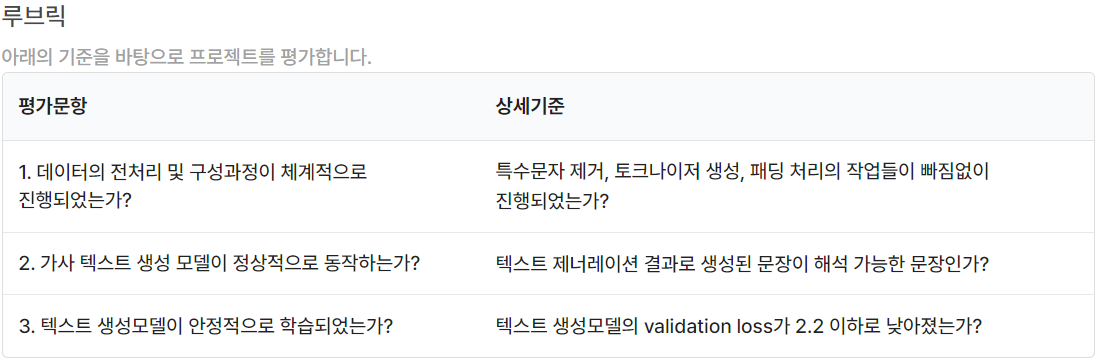

### 라이브러리 버전 확인

In [1]:
import os, re, glob
import numpy as np
import tensorflow as tf
from sklearn.model_selection import train_test_split
from keras import callbacks

print(tf.__version__)

2.6.0


### 데이터 읽어오기

In [2]:
txt_file_path = os.getenv('HOME')+'/aiffel/lyricist/data/lyrics/*'
txt_list = glob.glob(txt_file_path)

raw_corpus = [] 

for txt_file in txt_list:
    with open(txt_file, "r") as f:
        raw = f.read().splitlines()
        raw_corpus.extend(raw)

print("데이터 크기:", len(raw_corpus))
print("Examples:\n", raw_corpus[:9])

데이터 크기: 187088
Examples:
 ['', '', '[Spoken Intro:]', 'You ever want something ', "that you know you shouldn't have ", "The more you know you shouldn't have it, ", 'The more you want it ', 'And then one day you get it, ', "It's so good too "]


### 데이터 정제

In [3]:
def preprocess_sentence(sentence):
    sentence = sentence.lower().strip()
    sentence = re.sub(r"([?.!,¿])", r" \1 ", sentence)
    sentence = re.sub(r'[" "]+', " ", sentence)
    sentence = re.sub(r"[^a-zA-Z?.!,¿]+", " ", sentence)
    sentence = sentence.strip()
    sentence = '<start> ' + sentence + ' <end>'
    return sentence

In [4]:
corpus = []

for sentence in raw_corpus:
    if len(sentence) == 0:
        continue
    if sentence[-1] == "]":
        continue
    preprocessed_sentence = preprocess_sentence(sentence)
    corpus.append(preprocessed_sentence)
        
corpus[:10]

['<start> spoken intro <end>',
 '<start> you ever want something <end>',
 '<start> that you know you shouldn t have <end>',
 '<start> the more you know you shouldn t have it , <end>',
 '<start> the more you want it <end>',
 '<start> and then one day you get it , <end>',
 '<start> it s so good too <end>',
 '<start> but it s just like my girl <end>',
 '<start> when she s around me <end>',
 '<start> i just feel so good , so good <end>']

In [5]:
def tokenize(corpus):
    tokenizer = tf.keras.preprocessing.text.Tokenizer(
        num_words=16384, 
        filters=' ',
        oov_token="<unk>"
    )
    tokenizer.fit_on_texts(corpus)
    tensor = tokenizer.texts_to_sequences(corpus)
    tensor = tf.keras.preprocessing.sequence.pad_sequences(tensor, padding='post',maxlen=15)
    
    print(tensor,tokenizer)
    return tensor, tokenizer

tensor, tokenizer = tokenize(corpus)

[[   2 2701 2584 ...    0    0    0]
 [   2    7  156 ...    0    0    0]
 [   2   17    7 ...    0    0    0]
 ...
 [   2  311    1 ...    0    0    0]
 [   5   34   45 ... 1161  143    3]
 [   5   34   45 ... 1161  143    3]] <keras_preprocessing.text.Tokenizer object at 0x7fe30052f280>


In [6]:
print(tensor[:3])

[[   2 2701 2584    3    0    0    0    0    0    0    0    0    0    0
     0]
 [   2    7  156   62  199    3    0    0    0    0    0    0    0    0
     0]
 [   2   17    7   34    7 1518   15   76    3    0    0    0    0    0
     0]]


In [7]:
for idx in tokenizer.index_word:
    print(idx, ":", tokenizer.index_word[idx])

    if idx >= 10:
        break

1 : <unk>
2 : <start>
3 : <end>
4 : ,
5 : i
6 : the
7 : you
8 : and
9 : a
10 : to


In [8]:
src_input = tensor[:, :-1]
tgt_input = tensor[:, 1:]    

print(src_input[0])
print(tgt_input[0])

[   2 2701 2584    3    0    0    0    0    0    0    0    0    0    0]
[2701 2584    3    0    0    0    0    0    0    0    0    0    0    0]


In [9]:
BUFFER_SIZE = len(src_input)
BATCH_SIZE = 256
steps_per_epoch = len(src_input) // BATCH_SIZE

VOCAB_SIZE = tokenizer.num_words + 1   

dataset = tf.data.Dataset.from_tensor_slices((src_input, tgt_input))
dataset = dataset.shuffle(BUFFER_SIZE)
dataset = dataset.batch(BATCH_SIZE, drop_remainder=True)
dataset

<BatchDataset shapes: ((256, 14), (256, 14)), types: (tf.int32, tf.int32)>

### 평가 데이터셋 분리

In [10]:
enc_train, enc_val, dec_train, dec_val = train_test_split(src_input,
                                                          tgt_input,
                                                          test_size=0.2,
                                                          random_state=2023)

### 인공지능 만들기

In [11]:
class TextGenerator(tf.keras.Model):
    def __init__(self, vocab_size, embedding_size, hidden_size):
        super().__init__()
        self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_size) 
        self.rnn_1 = tf.keras.layers.LSTM(hidden_size, return_sequences=True)  
        self.rnn_2 = tf.keras.layers.LSTM(hidden_size, return_sequences=True)
        self.linear = tf.keras.layers.Dense(vocab_size)
        
    def call(self, x):
        out = self.embedding(x)
        out = self.rnn_1(out)
        out = self.rnn_2(out)
        out = self.linear(out)
        
        return out
    
embedding_size = 256
# embedding size 값이 커질수록 단어의 추상적인 특징들을 더 잡아낼 수 있지만 그만큼 충분한 데이터가 없으면 안좋은 결과 값을 가져옵니다!   
# 워드 벡터의 차원수를 말하며 단어가 추상적으로 표현되는 크기입니다.

hidden_size = 1024
# 모델에 얼마나 많은 일꾼을 둘 것인가? 정도로 이해하면 좋다.

model = TextGenerator(tokenizer.num_words + 1, embedding_size , hidden_size)

In [12]:
tf.test.is_gpu_available()

Instructions for updating:
Use `tf.config.list_physical_devices('GPU')` instead.


True

In [13]:
optimizer = tf.keras.optimizers.RMSprop()

loss = tf.keras.losses.SparseCategoricalCrossentropy( 
    from_logits=True,
    reduction='none')

model.compile(loss=loss, optimizer=optimizer)

check_point_cb = callbacks.ModelCheckpoint('text_generator', save_best_only=True)

early_stopping_cb = callbacks.EarlyStopping(patience=10, monitor='val_loss', restore_best_weights=True)

In [14]:
model.fit(dataset,
          epochs=30,
          validation_data=(enc_val, dec_val),
          callbacks=[check_point_cb, early_stopping_cb]
         )
# fit(
#     x=None,
#     y=None,
#     batch_size=None,
#     epochs=1,
#     verbose='auto',
#     callbacks=None,
#     validation_split=0.0,
#     validation_data=None,
#     shuffle=True,
#     class_weight=None,
#     sample_weight=None,
#     initial_epoch=0,
#     steps_per_epoch=None,
#     validation_steps=None,
#     validation_batch_size=None,
#     validation_freq=1,
#     max_queue_size=10,
#     workers=1,
#     use_multiprocessing=False
# )

Epoch 1/30
686/686 [==============================] - 157s 220ms/step - loss: 3.4797 - val_loss: 3.0591


INFO:tensorflow:Assets written to: text_generator/assets


INFO:tensorflow:Assets written to: text_generator/assets


Epoch 2/30
686/686 [==============================] - 151s 220ms/step - loss: 2.9796 - val_loss: 2.7939


INFO:tensorflow:Assets written to: text_generator/assets


INFO:tensorflow:Assets written to: text_generator/assets


Epoch 3/30
686/686 [==============================] - 151s 220ms/step - loss: 2.7709 - val_loss: 2.5837


INFO:tensorflow:Assets written to: text_generator/assets


INFO:tensorflow:Assets written to: text_generator/assets


Epoch 4/30
686/686 [==============================] - 151s 220ms/step - loss: 2.5901 - val_loss: 2.3914


INFO:tensorflow:Assets written to: text_generator/assets


INFO:tensorflow:Assets written to: text_generator/assets


Epoch 5/30
686/686 [==============================] - 152s 221ms/step - loss: 2.4175 - val_loss: 2.2092


INFO:tensorflow:Assets written to: text_generator/assets


INFO:tensorflow:Assets written to: text_generator/assets


Epoch 6/30
686/686 [==============================] - 152s 221ms/step - loss: 2.2547 - val_loss: 2.0423


INFO:tensorflow:Assets written to: text_generator/assets


INFO:tensorflow:Assets written to: text_generator/assets


Epoch 7/30
686/686 [==============================] - 152s 221ms/step - loss: 2.0997 - val_loss: 1.8899


INFO:tensorflow:Assets written to: text_generator/assets


INFO:tensorflow:Assets written to: text_generator/assets


Epoch 8/30
686/686 [==============================] - 152s 221ms/step - loss: 1.9599 - val_loss: 1.7555


INFO:tensorflow:Assets written to: text_generator/assets


INFO:tensorflow:Assets written to: text_generator/assets


Epoch 9/30
686/686 [==============================] - 152s 221ms/step - loss: 1.8324 - val_loss: 1.6396


INFO:tensorflow:Assets written to: text_generator/assets


INFO:tensorflow:Assets written to: text_generator/assets


Epoch 10/30
686/686 [==============================] - 152s 221ms/step - loss: 1.7299 - val_loss: 1.5492


INFO:tensorflow:Assets written to: text_generator/assets


INFO:tensorflow:Assets written to: text_generator/assets


Epoch 11/30
686/686 [==============================] - 152s 221ms/step - loss: 1.6397 - val_loss: 1.4648


INFO:tensorflow:Assets written to: text_generator/assets


INFO:tensorflow:Assets written to: text_generator/assets


Epoch 12/30
686/686 [==============================] - 152s 221ms/step - loss: 1.5607 - val_loss: 1.4008


INFO:tensorflow:Assets written to: text_generator/assets


INFO:tensorflow:Assets written to: text_generator/assets


Epoch 13/30
686/686 [==============================] - 152s 221ms/step - loss: 1.4982 - val_loss: 1.3536


INFO:tensorflow:Assets written to: text_generator/assets


INFO:tensorflow:Assets written to: text_generator/assets


Epoch 14/30
686/686 [==============================] - 152s 221ms/step - loss: 1.4491 - val_loss: 1.3111


INFO:tensorflow:Assets written to: text_generator/assets


INFO:tensorflow:Assets written to: text_generator/assets


Epoch 15/30
686/686 [==============================] - 152s 221ms/step - loss: 1.4063 - val_loss: 1.2757


INFO:tensorflow:Assets written to: text_generator/assets


INFO:tensorflow:Assets written to: text_generator/assets


Epoch 16/30
686/686 [==============================] - 152s 221ms/step - loss: 1.3656 - val_loss: 1.2424


INFO:tensorflow:Assets written to: text_generator/assets


INFO:tensorflow:Assets written to: text_generator/assets


Epoch 17/30
686/686 [==============================] - 152s 221ms/step - loss: 1.3310 - val_loss: 1.2147


INFO:tensorflow:Assets written to: text_generator/assets


INFO:tensorflow:Assets written to: text_generator/assets


Epoch 18/30
686/686 [==============================] - 152s 221ms/step - loss: 1.3045 - val_loss: 1.1957


INFO:tensorflow:Assets written to: text_generator/assets


INFO:tensorflow:Assets written to: text_generator/assets


Epoch 19/30
686/686 [==============================] - 152s 221ms/step - loss: 1.2845 - val_loss: 1.1808


INFO:tensorflow:Assets written to: text_generator/assets


INFO:tensorflow:Assets written to: text_generator/assets


Epoch 20/30
686/686 [==============================] - 152s 221ms/step - loss: 1.2686 - val_loss: 1.1672


INFO:tensorflow:Assets written to: text_generator/assets


INFO:tensorflow:Assets written to: text_generator/assets


Epoch 21/30
686/686 [==============================] - 152s 221ms/step - loss: 1.2544 - val_loss: 1.1577


INFO:tensorflow:Assets written to: text_generator/assets


INFO:tensorflow:Assets written to: text_generator/assets


Epoch 22/30
686/686 [==============================] - 152s 221ms/step - loss: 1.2430 - val_loss: 1.1473


INFO:tensorflow:Assets written to: text_generator/assets


INFO:tensorflow:Assets written to: text_generator/assets


Epoch 23/30
686/686 [==============================] - 152s 221ms/step - loss: 1.2318 - val_loss: 1.1409


INFO:tensorflow:Assets written to: text_generator/assets


INFO:tensorflow:Assets written to: text_generator/assets


Epoch 24/30
686/686 [==============================] - 152s 221ms/step - loss: 1.2243 - val_loss: 1.1373


INFO:tensorflow:Assets written to: text_generator/assets


INFO:tensorflow:Assets written to: text_generator/assets


Epoch 25/30
686/686 [==============================] - 152s 221ms/step - loss: 1.2207 - val_loss: 1.1370


INFO:tensorflow:Assets written to: text_generator/assets


INFO:tensorflow:Assets written to: text_generator/assets


Epoch 26/30
686/686 [==============================] - 152s 221ms/step - loss: 1.2196 - val_loss: 1.1353


INFO:tensorflow:Assets written to: text_generator/assets


INFO:tensorflow:Assets written to: text_generator/assets


Epoch 27/30
686/686 [==============================] - 152s 221ms/step - loss: 1.2195 - val_loss: 1.1374
Epoch 28/30
686/686 [==============================] - 151s 220ms/step - loss: 1.2207 - val_loss: 1.1387
Epoch 29/30
686/686 [==============================] - 151s 220ms/step - loss: 1.2210 - val_loss: 1.1386
Epoch 30/30
686/686 [==============================] - 151s 220ms/step - loss: 1.2197 - val_loss: 1.1368


In [15]:
model.summary()

Model: "text_generator"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        multiple                  4194560   
_________________________________________________________________
lstm (LSTM)                  multiple                  5246976   
_________________________________________________________________
lstm_1 (LSTM)                multiple                  8392704   
_________________________________________________________________
dense (Dense)                multiple                  16794625  
Total params: 34,628,865
Trainable params: 34,628,865
Non-trainable params: 0
_________________________________________________________________


### 평가하기

In [17]:
def generate_text(model, tokenizer, init_sentence="<start>", max_len=20):
    test_input = tokenizer.texts_to_sequences([init_sentence])
    test_tensor = tf.convert_to_tensor(test_input, dtype=tf.int64)
    end_token = tokenizer.word_index["<end>"]
    
    while True:
        predict = model(test_tensor)
        predict_word = tf.argmax(tf.nn.softmax(predict, axis=-1), axis=-1)[:, -1]
        test_tensor = tf.concat([test_tensor, tf.expand_dims(predict_word, axis=0)], axis=-1)
        if predict_word.numpy()[0] == end_token:
            break
        if test_tensor.shape[1] >= max_len:
            break
    generated = ""
    for word_index in test_tensor[0].numpy():
        generated += tokenizer.index_word[word_index] + " "
    return generated

In [19]:
generate_text(model, tokenizer, init_sentence="<start> i love", max_len=60)

'<start> i love you more that i did <end> '

In [20]:
generate_text(model, tokenizer, init_sentence="<start> what", max_len=60)

'<start> what do you mean ? <end> '

In [21]:
generate_text(model, tokenizer, init_sentence="<start> spring", max_len=60)

'<start> spring is here again <end> '

In [22]:
generate_text(model, tokenizer, init_sentence="<start> one", max_len=60)

'<start> one , two , three , four , five , six , seven <end> '

In [23]:
generate_text(model, tokenizer, init_sentence="<start> when", max_len=60)

'<start> when i m with you , all i get is wild thoughts <end> '

In [24]:
generate_text(model, tokenizer, init_sentence="<start> korean", max_len=60)

'<start> <unk> <end> '

In [25]:
generate_text(model, tokenizer, init_sentence="<start> korea", max_len=60)

'<start> korea is where i came to <end> '

### 회고

#### 어려웠던 점, 해결을 위해 시도한 방법, 문제해결에 성공한 이유 또는 실패한 이유
    : 모델을 학습시키는 동안 val_loss가 10 epoch 안에 2.2 이하가 되는 지 확인하기 위해 기다려야하는 게 힘들었다. 처음에는 RMSprop으로 5 epoch만에 val_loss가 1점대가 나와서 빠르게 할 수 있을 것 같다는 생각을 했는데, 단어장을 12000 이상으로 하지 않고 7000으로 했다는 걸 알고 다시 해야 했다. 한 번 돌리는 것 만으로 빠르게 끝내고 싶어서 다음에 또 사용할 부분이 뭐가 없는 지 확인했고, earlystopping과 callback도 추가했다.
    
#### 프로젝트를 진행하면서 알아낸 점 혹은 아직 모호한 점
    : init_sentence를 <start>로 알려주고 학습을 시키는 게 신기했다. 이래서 chatgpt랑 대화하다 보면 문장의 끝맺음이 이상하다고 느낄 때가 있었는데 학습한 문장의 <end>가 끝맺음이 이상했나보다.
    
#### 루브릭 평가 지표를 맞추기 위해 시도한 내용
    : maxlen을 15로 했다. 옵티마이저를 rmsprop으로 변경했다. 단어장 크기를 16384로 했다.
    
#### 자기 다짐, 프로젝트를 진행하면서 느낀점
    : 에폭이 돌아가는 동안 할만한 걸 찾아야겠다.